In [232]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
#linear regression: 
from sklearn.linear_model import LinearRegression


In [233]:
import sys
sys.path.append('./models/')
df=pd.read_csv('hopitalized_and_infectious.csv')
df.drop(['Unnamed: 0'], axis=1, inplace=True)
n_hospitalized=np.array(df['hospitalized'])
n_infectious=np.array(df['n_infectious'])


# importing mobility from the csv file
df_mobility=pd.read_csv('mobility_bis.csv')
df_mobility.drop(columns=['Unnamed: 0'], inplace=True)
mobility=np.array(df_mobility['mobility'])

relier_les_points=[]
for i in range(len(mobility)): 
    if i + 7 < len(mobility): 
        if i % 7 ==0:
            relier_les_points.append(mobility[i])
        else: 
            decalage=i-7*(i//7)
            res = (1-decalage/7)*mobility[7*(i//7)] + (decalage/7)*mobility[7*(i//7)+7]

            relier_les_points.append(res)
    else:
        relier_les_points.append(mobility[i])
mobility_smoothed=np.array(relier_les_points)
data3D=np.array([n_hospitalized, n_infectious, mobility_smoothed])





In [234]:
import numpy as np 
from Model import Model
from sklearn.linear_model import LinearRegression
import scipy.stats



def predict_model(model, data_train,y_train,  reach): 
    prediction_reach_days_ahead=[]
    a=np.concatenate((data_train[-1], np.array([y_train[-1]])))[1:]
    predict=model.predict(a.reshape(1, -1))
    prediction_reach_days_ahead.append(predict)
    for i in range(1, reach):
        a=np.concatenate((a[1:], predict))
        predict=model.predict(a.reshape(1, -1))
        prediction_reach_days_ahead.append(predict)
    return np.array(prediction_reach_days_ahead)

def estimate_sigma2(linear_regression, data, y): 
    predictions = linear_regression.predict(data)
    d=linear_regression.coef_.shape[0]
    n=len(y)
    sigma2=np.sum((predictions -y )**2)/(n-d) # unbiased estimator of the variance of the noise
    return sigma2


def computa_covariance_matrix(linear_regression, data, y): 
    sigma2=estimate_sigma2(linear_regression, data, y)
    # X=np.concatenate((np.ones((len(data), 1)), data), axis=1)
    X=data
    return np.linalg.inv(np.dot(X.T, X))*sigma2

class LinearRegressionModel(Model):
    

    def train(self, dates_of_pandemic_train, datatrain): 
        n_days=min(len(dates_of_pandemic_train), 30)
        lr=LinearRegression()
        data=[]
        y=[]
        for i in range(n_days, len(datatrain)): 
            data.append(datatrain[i-n_days:i])
            y.append(datatrain[i])
        data=np.array(data)
        self.mydata=data
        self.results=lr.fit(data, y)
        self.model=lr
        self.data=datatrain
        self.trained=True
        self.y=y
    

    def predict(self, reach, alpha): 
        prediction = predict_model(self.model, self.mydata, self.y, reach)
        covariance_matrix=computa_covariance_matrix(self.model, self.mydata, self.y)
        last_day=self.mydata[-1]
        last_y=self.y[-1]
        ci_inf=[]
        ci_up=[]
        x=np.concatenate((last_day[1:], np.array([last_y]))).reshape(len(last_day), 1)
        self.x=x
        self.covariance_matrix=covariance_matrix    
        for i in range(reach):
            varp=np.matmul(x.T ,np.matmul( covariance_matrix , x))
            ci_inf.append(scipy.stats.norm.ppf(alpha/2, loc=prediction[i], scale=np.sqrt(varp))[0])
            ci_up.append(scipy.stats.norm.ppf(1-alpha/2, loc=prediction[i], scale=np.sqrt(varp))[0])
            x=np.concatenate((x[1:], prediction[i].reshape(1, 1)))
        return prediction, np.array([ci_inf, ci_up]).reshape(2, 7)



        
           

In [235]:
split=105

In [236]:
number_of_points=15
data_rf=[]
y_rf=[]
for i in range(number_of_points, len(n_hospitalized)): 
    data_rf.append(n_hospitalized[i-number_of_points:i])
    y_rf.append(n_hospitalized[i])
data_rf=np.array(data_rf)


In [237]:
lr=LinearRegression()
lr.fit(data_rf[:split], y_rf[:split])
predict=lr.predict(data_rf[split:])

In [238]:
# from LinearRegression import *
linereg=LinearRegressionModel()

In [239]:
linereg.train([i for i in range(len(n_hospitalized[:split]))], n_hospitalized[:split])

In [240]:
x=np.array([1, 2, 3, 4, 5, 6, 7]).reshape(7, 1)
np.matmul(x.T, x)

array([[140]])

In [241]:
pred, ints =linereg.predict(7, 0.05)
np.array(ints).reshape(2, 7)

array([[567.76414025, 583.00392105, 584.45566983, 591.77555237,
        611.98078693, 626.83751148, 636.0534765 ],
       [604.31370094, 617.70834391, 621.60898429, 626.39620489,
        644.74260939, 659.88475713, 667.95511727]])

In [242]:
np.array(ints[0]).shape

(7,)

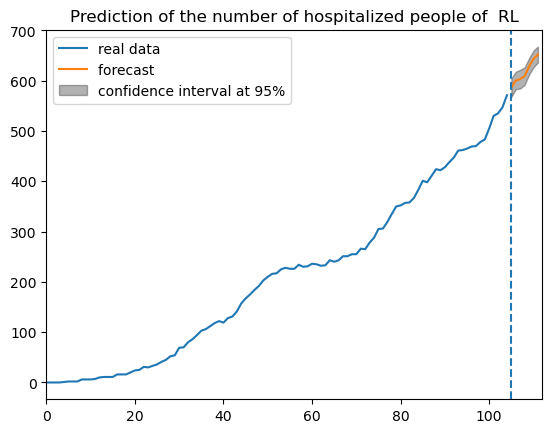

In [246]:
linereg.plot(7, 0.05, title='Prediction of the number of hospitalized people of  RL')


In [30]:
np.matmul(data_test[0], lr.coef_)

5646.120788008818

In [27]:
lr.predict(data_test[0].reshape(1, -1))

array([5647.52055033])

In [26]:
lr.coef_

array([ 0.0856796 ,  0.0390765 , -0.09622001, -0.16844992,  0.17993824,
       -0.02656199, -0.10634667,  0.21117316,  0.01650021, -0.20285347,
       -0.01809311,  0.0291757 , -0.05603028,  0.10729452, -0.05971711,
        0.04382708, -0.15750555,  0.03494013, -0.19900449,  1.34626215])

In [38]:
datatrain[-1], y_train[-1]

(array([3639., 3725., 3797., 3889., 3996., 4089., 4182., 4302., 4360.,
        4418., 4533., 4644., 4760., 4885., 5010., 5128., 5201., 5322.,
        5393., 5456.]),
 5556.0)

In [32]:
def estimate_sigma2(linear_regression, data, y): 
    predictions = linear_regression.predict(data)
    sigma2=np.sum((predictions -y )**2)/(len(y) - len(predictions )) # unbiased estimator of the variance of the noise
    return sigma2


def computa_covariance_matrix(linear_regression, data, y): 
    sigma2=estimate_sigma2(linear_regression, data, y)
    X=np.concatenate((np.ones((len(data), 1)), data), axis=1)
    return np.linalg.inv(np.dot(X.T, X))*sigma2

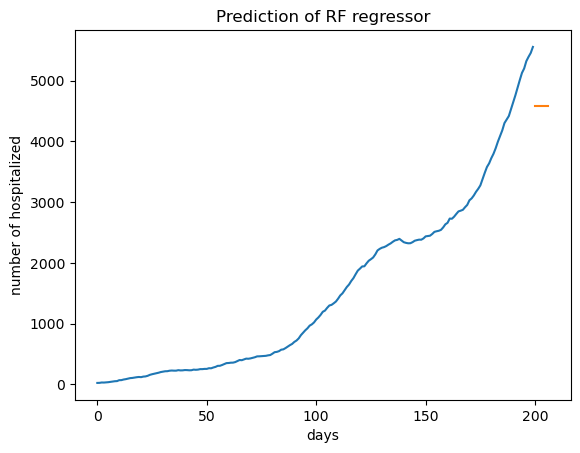

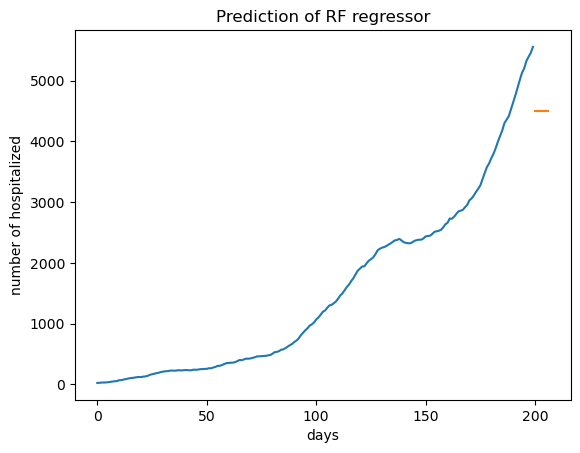

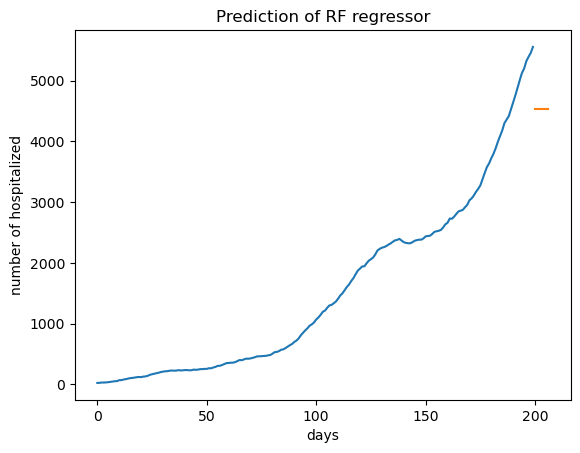

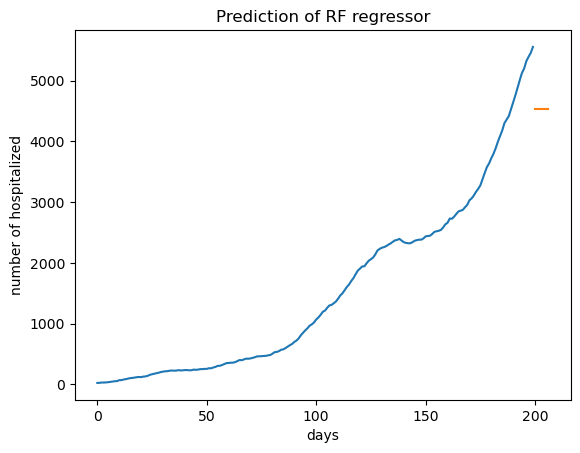

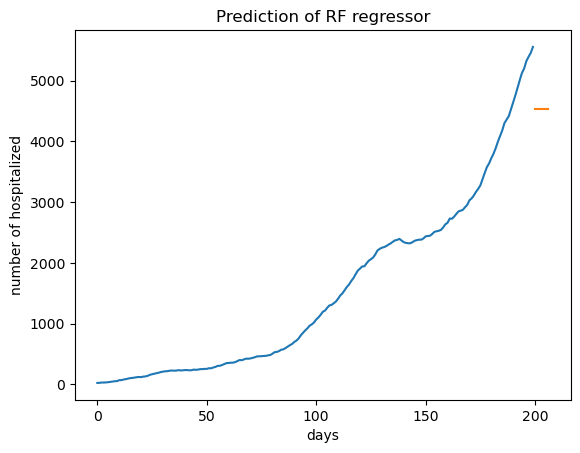

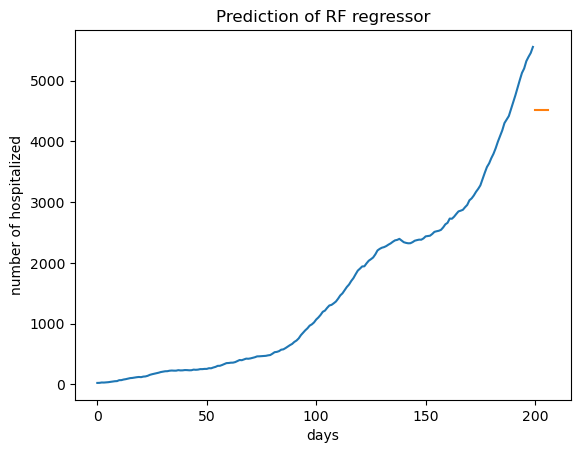

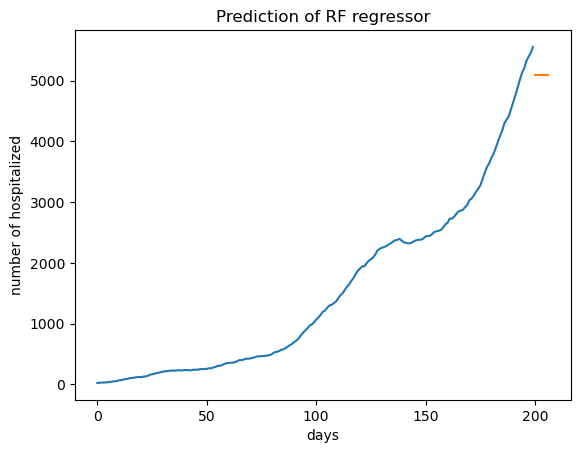

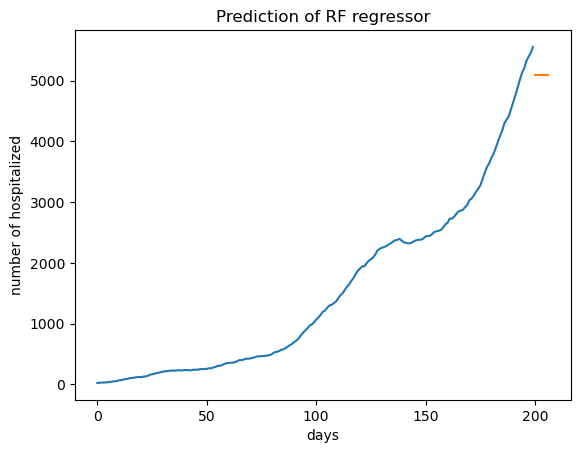

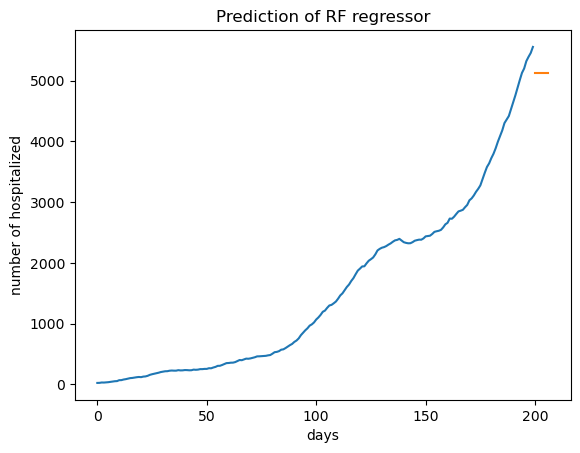

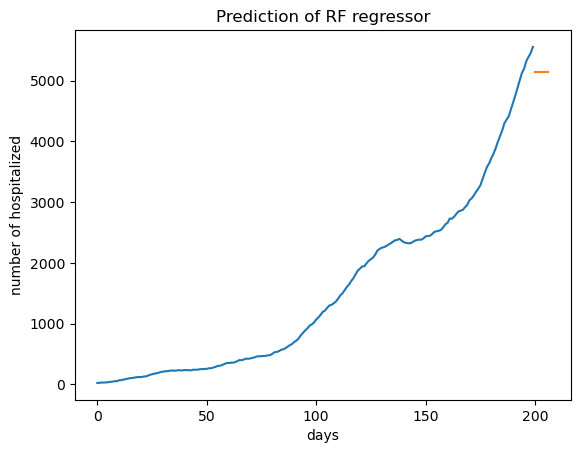

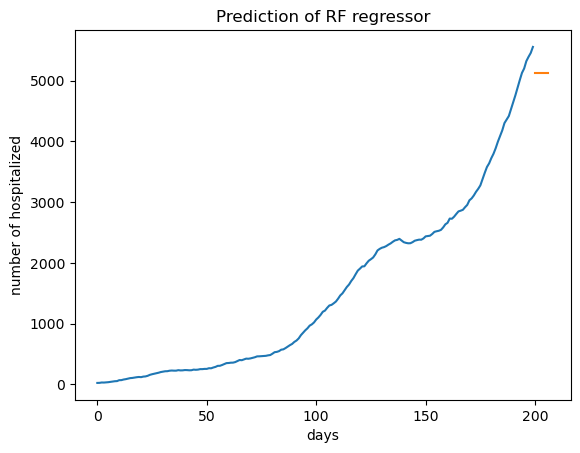

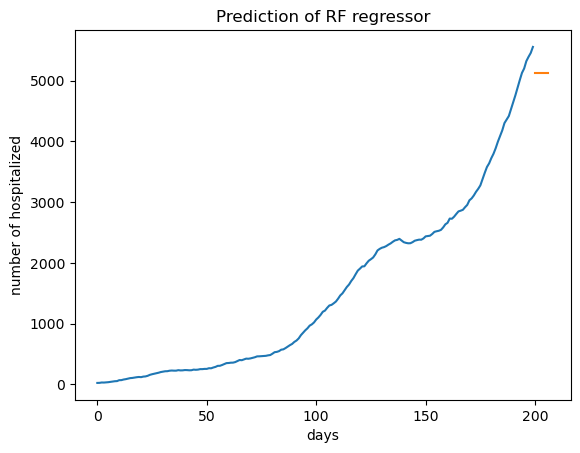

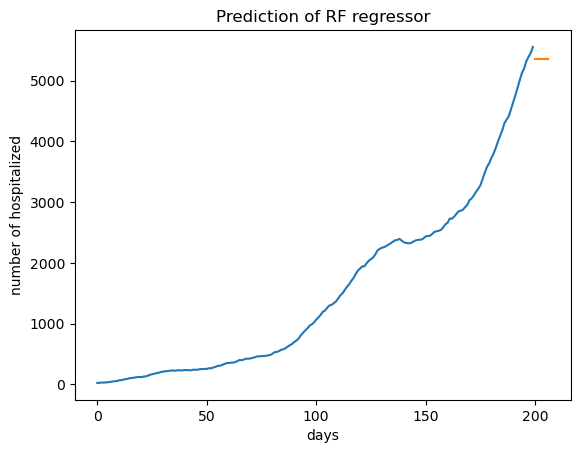

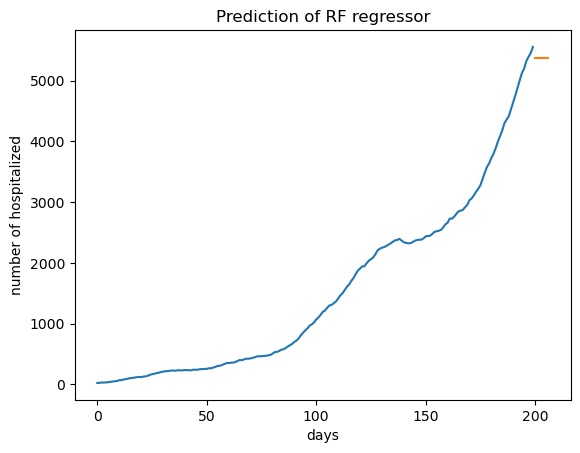

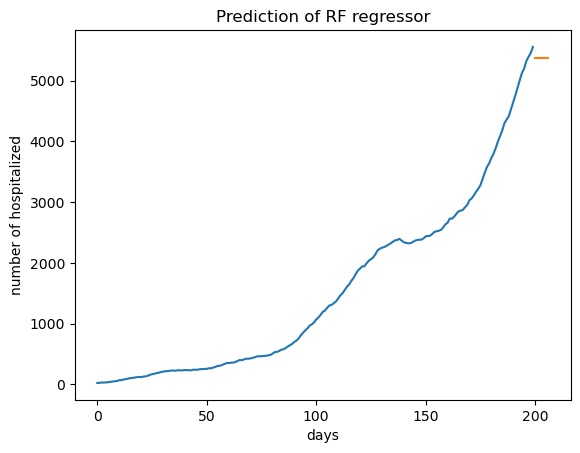

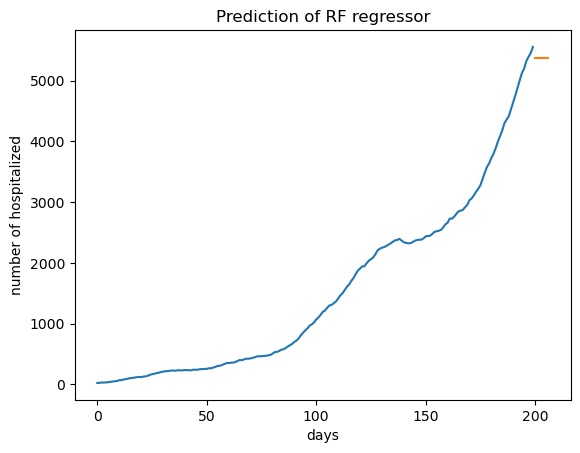

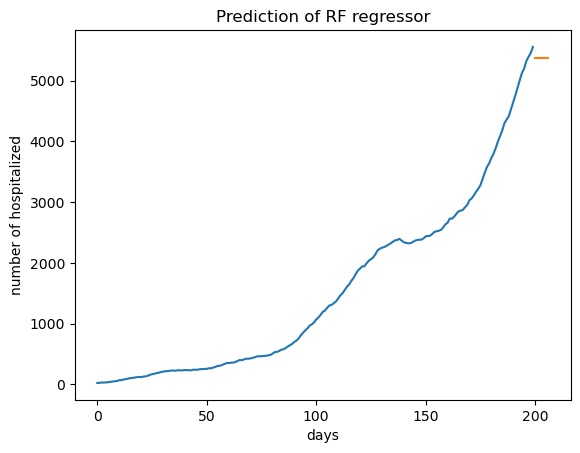

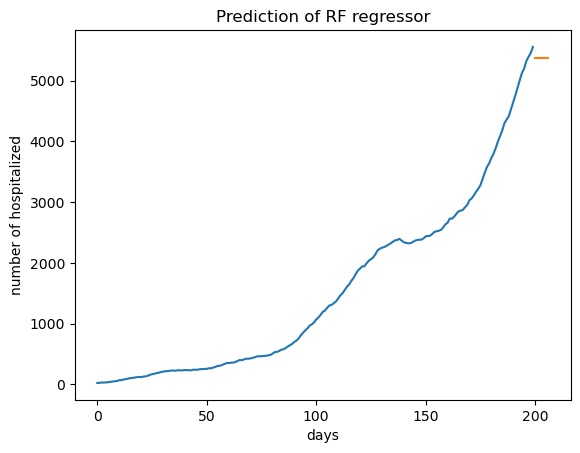

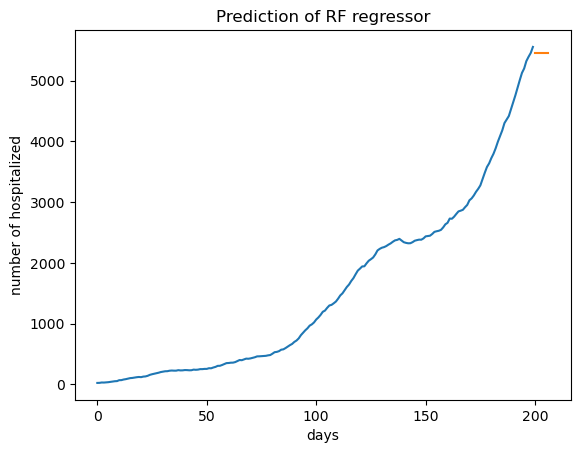

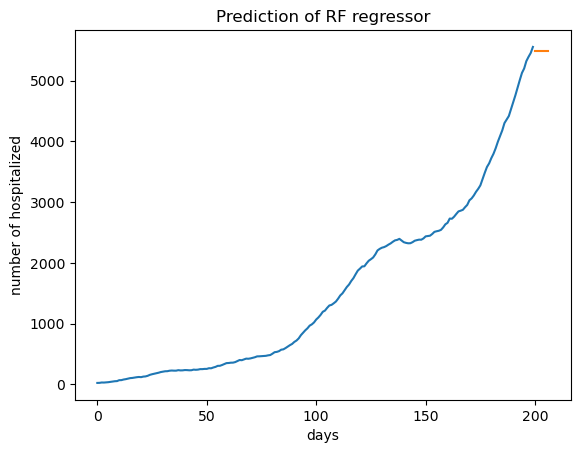

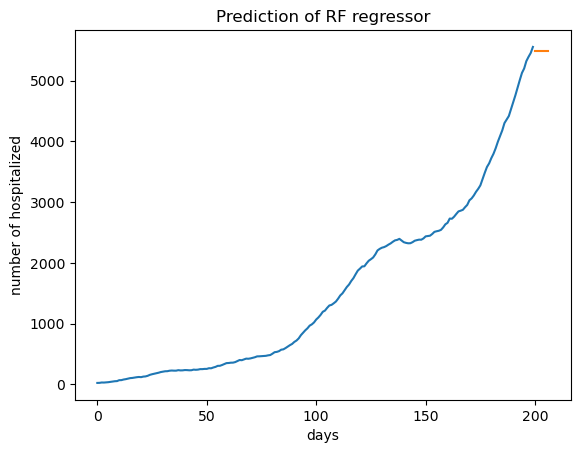

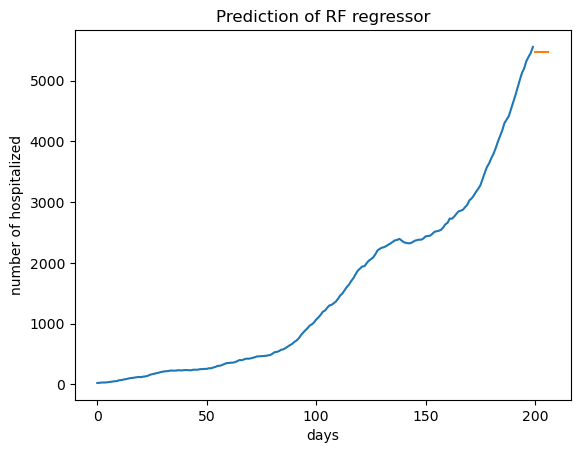

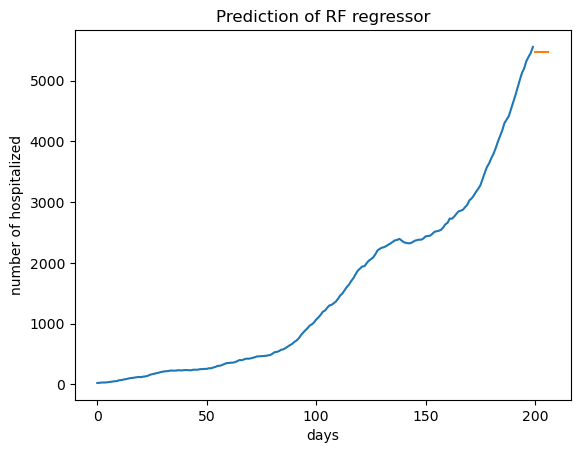

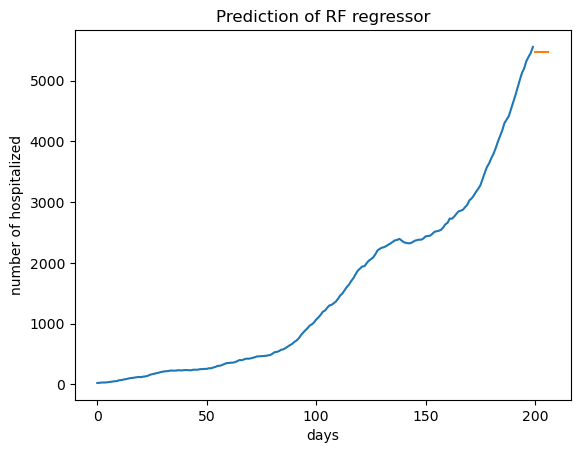

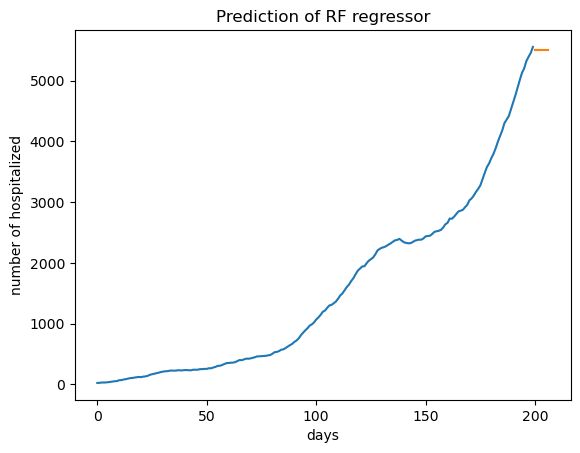

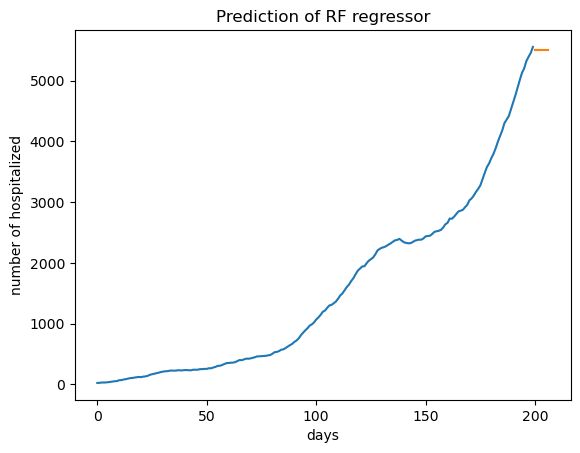

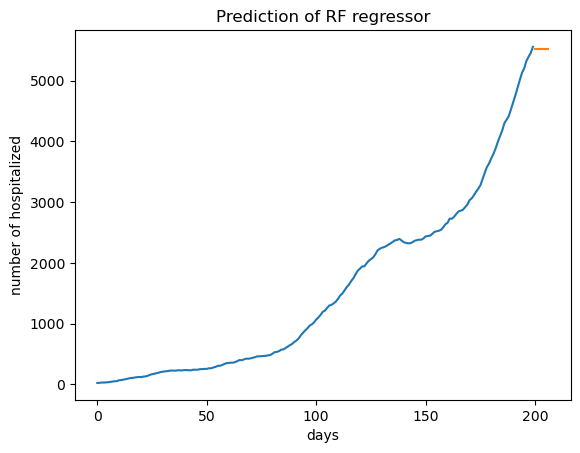

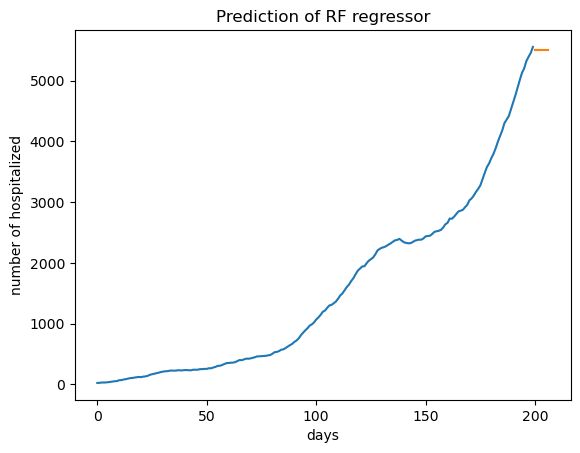

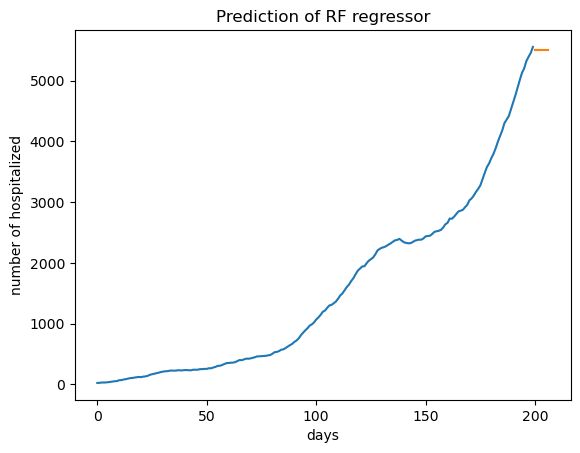

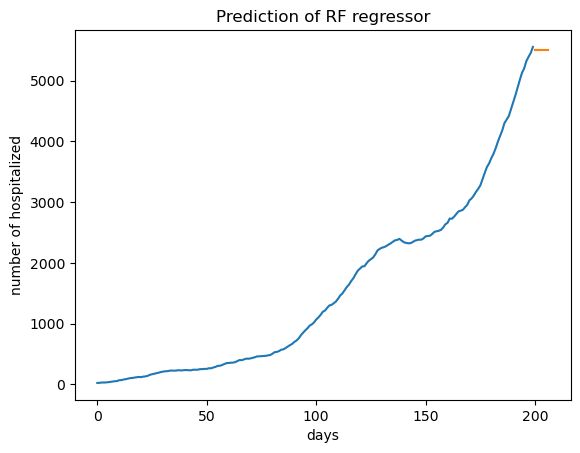

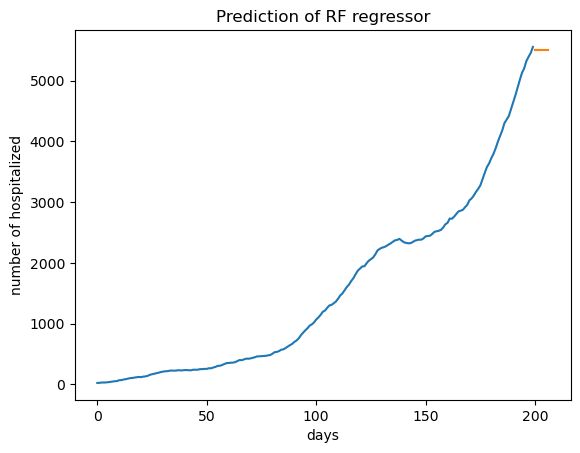

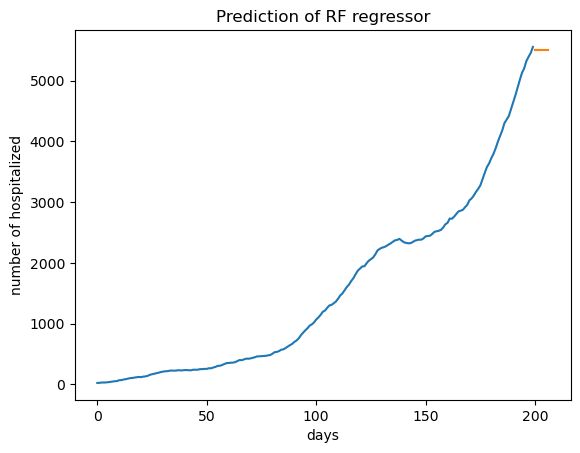

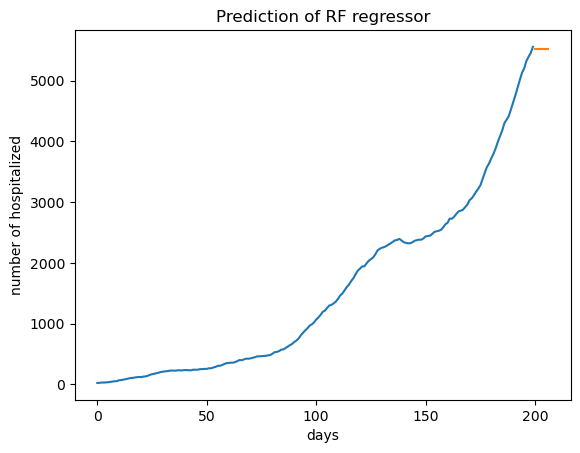

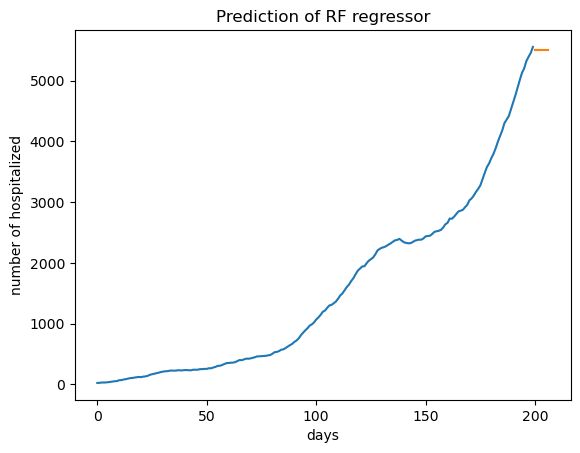

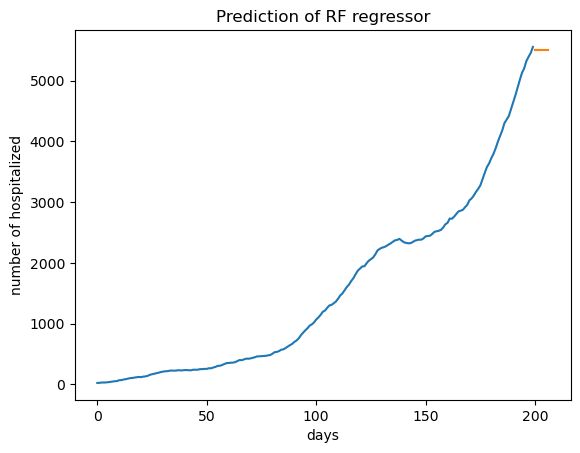

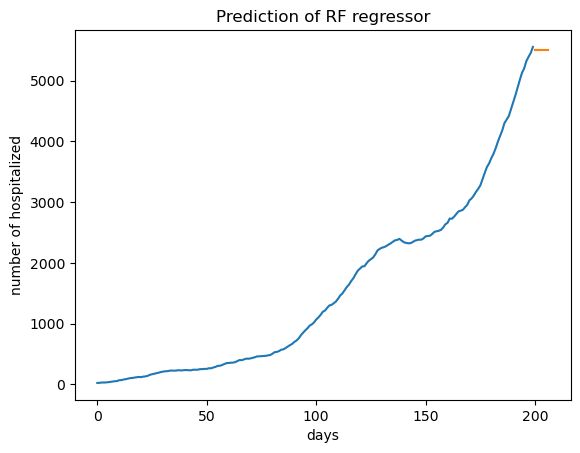

In [10]:
for depth in [2, 3, 4, 5, 6, 7]: 
    for n_estim in [10, 20, 50, 100, 150, 200]: 
        rf=RandomForestRegressor(max_depth=depth,  n_estimators=n_estim)
        rf.fit(datatrain, y_train)

        plt.plot(y_train)

        plt.plot([i for i in range(len(y_train), len(y_train)+7)], predict_model(rf, datatrain, y_train,  7), label='predict')
        plt.title('Prediction of RF regressor')
        plt.xlabel('days')
        plt.ylabel('number of hospitalized')
        plt.show()

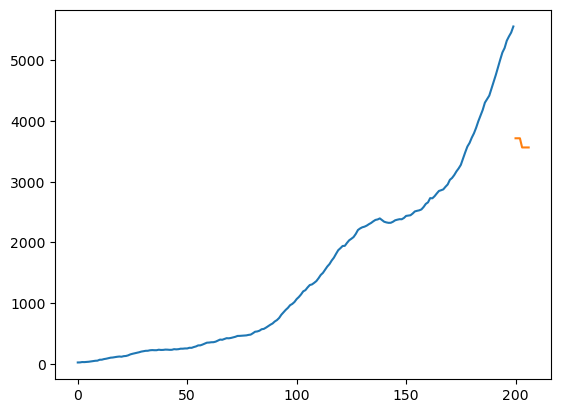

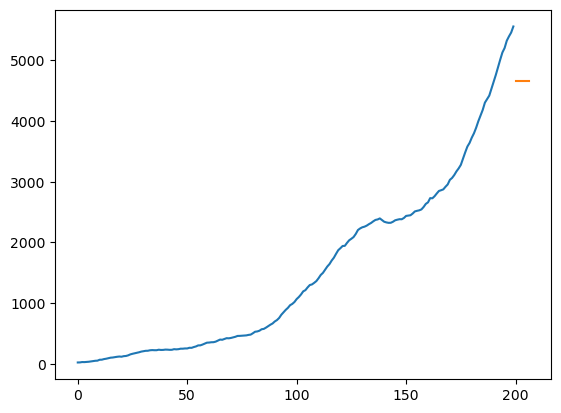

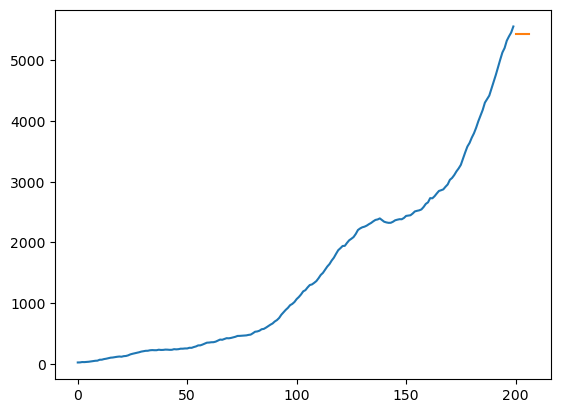

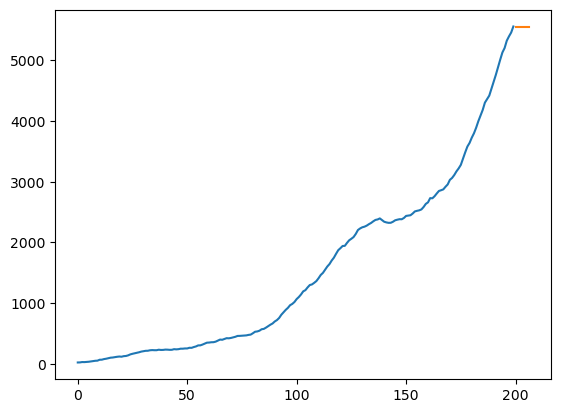

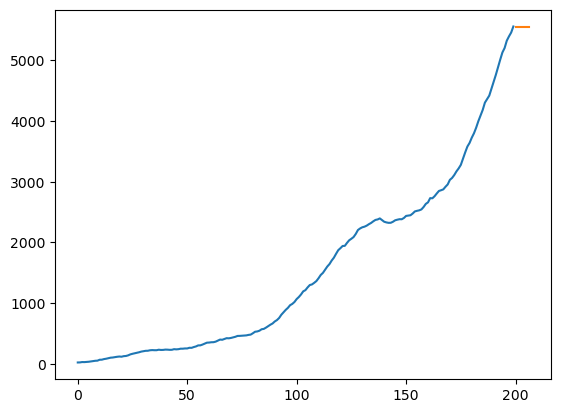

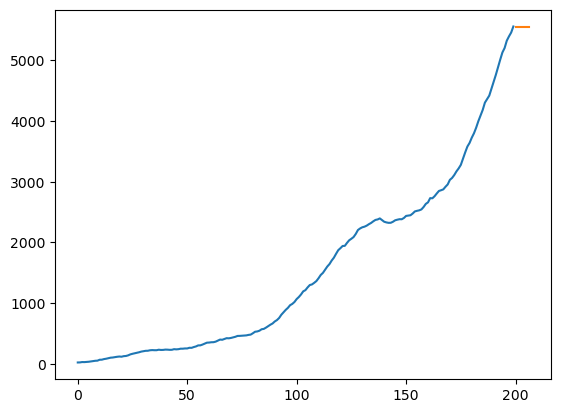

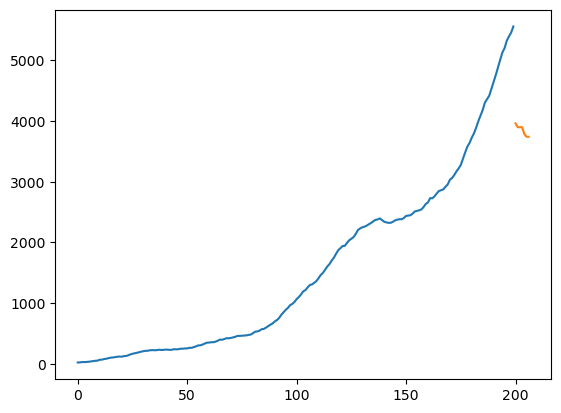

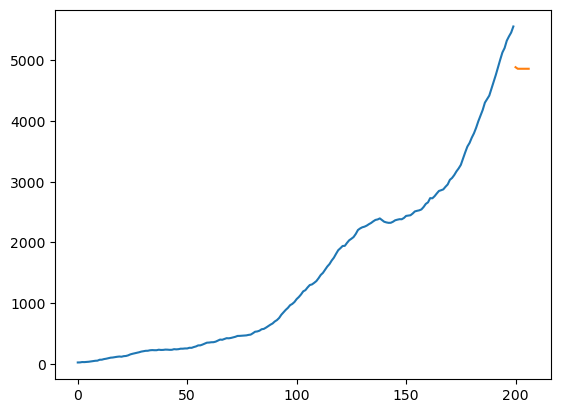

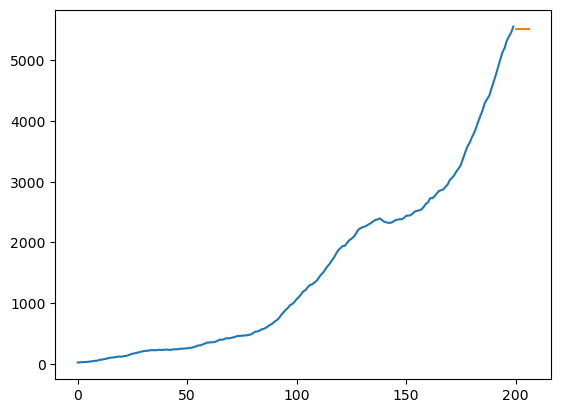

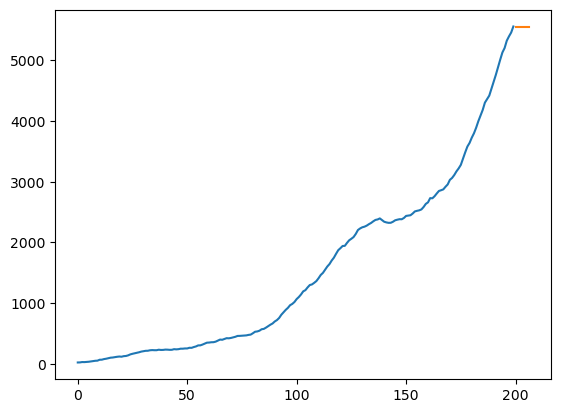

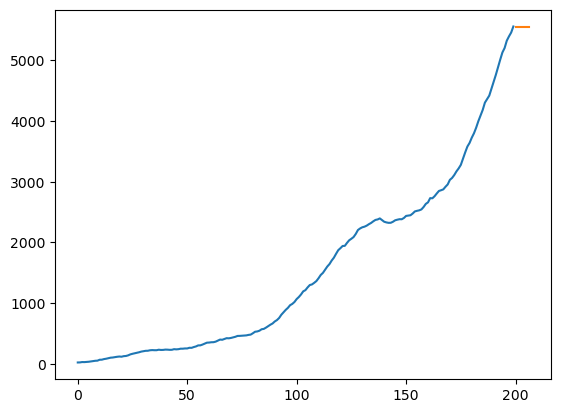

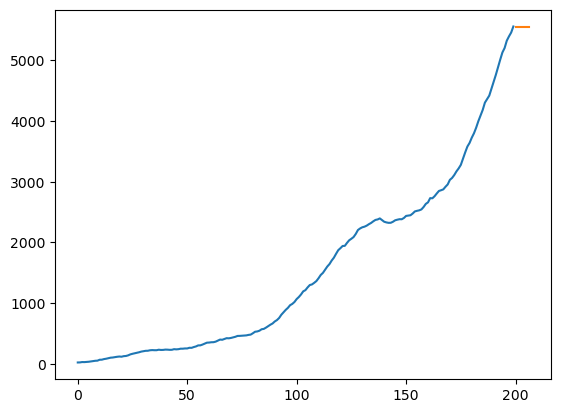

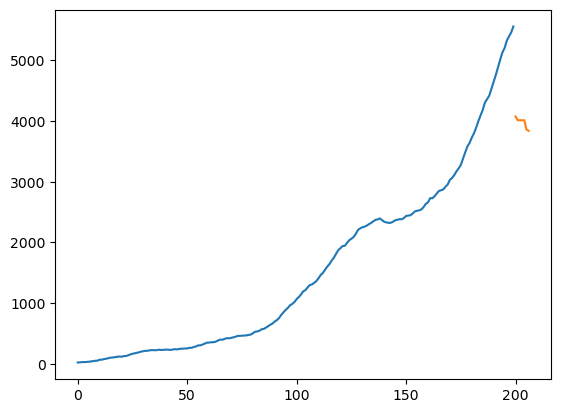

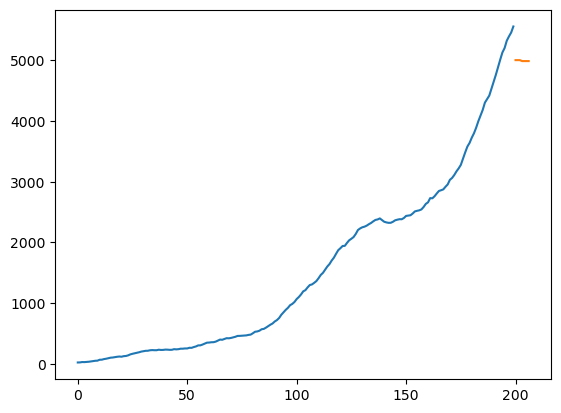

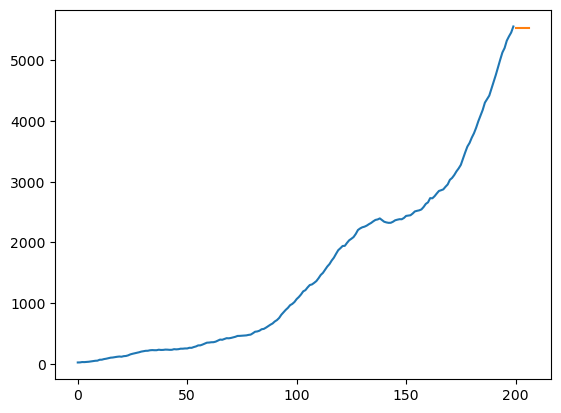

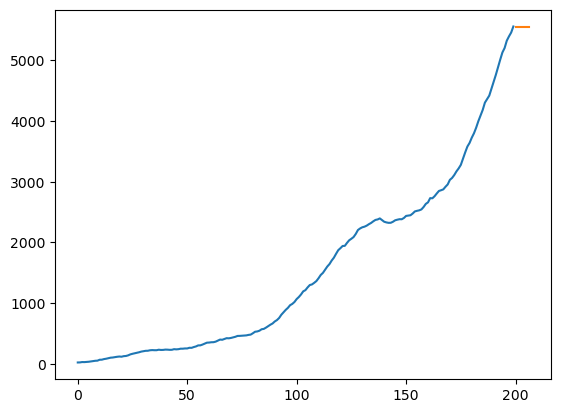

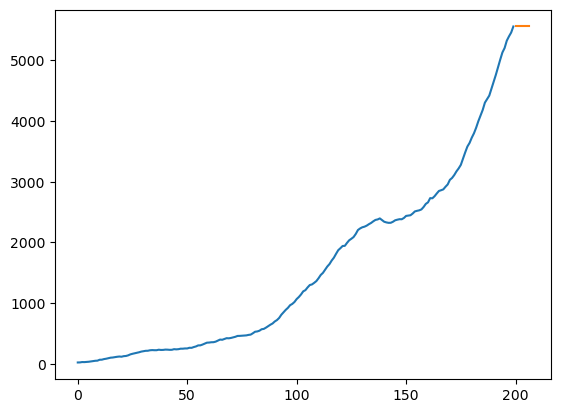

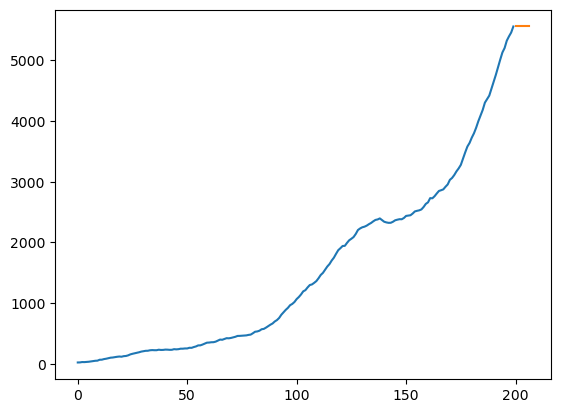

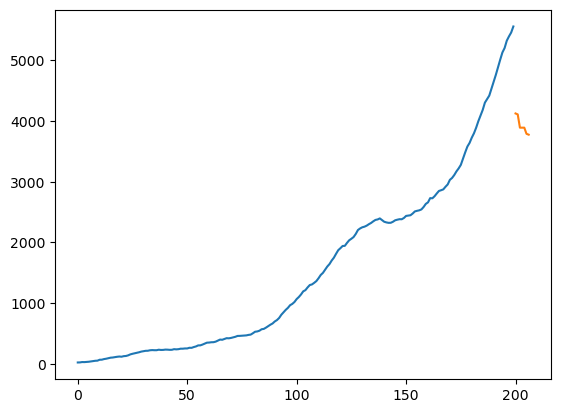

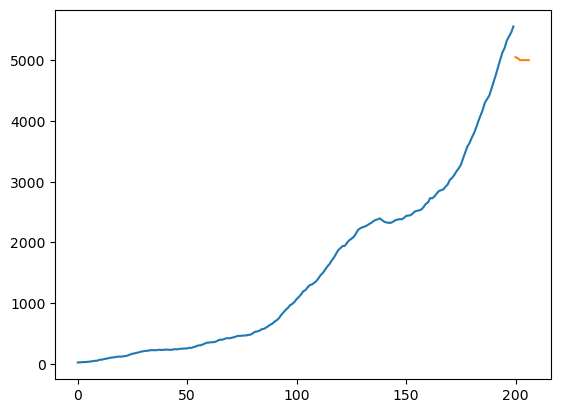

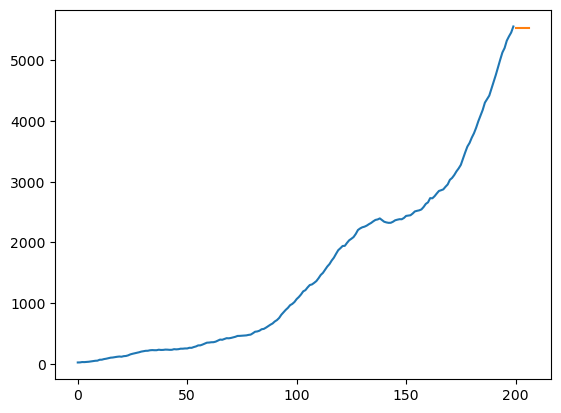

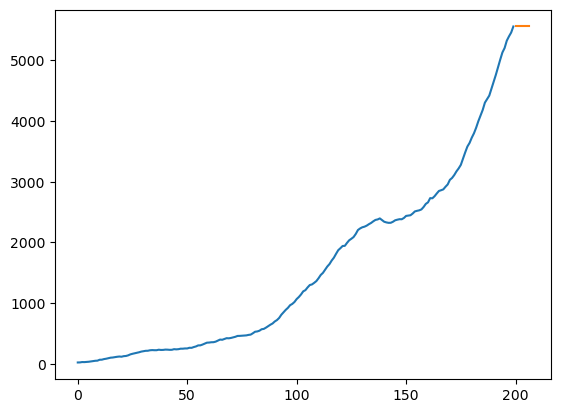

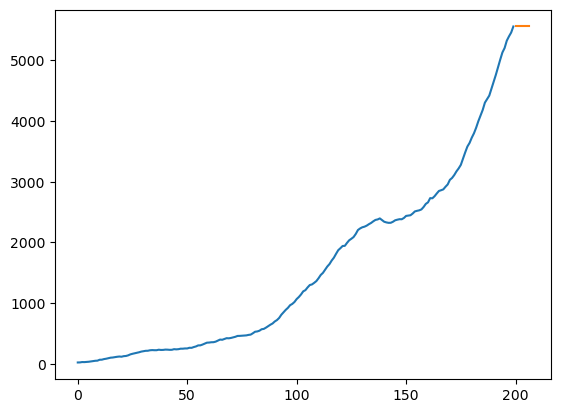

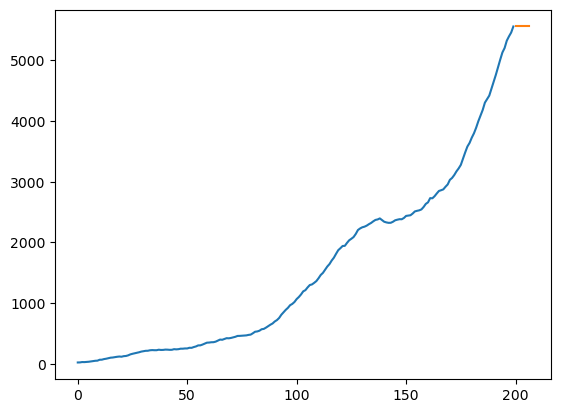

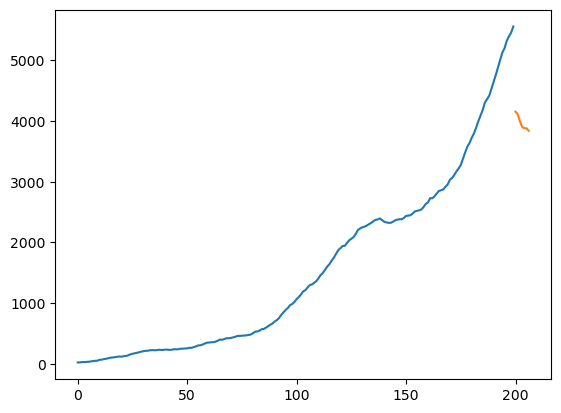

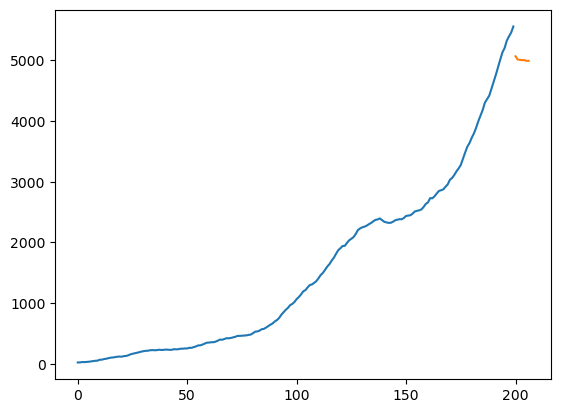

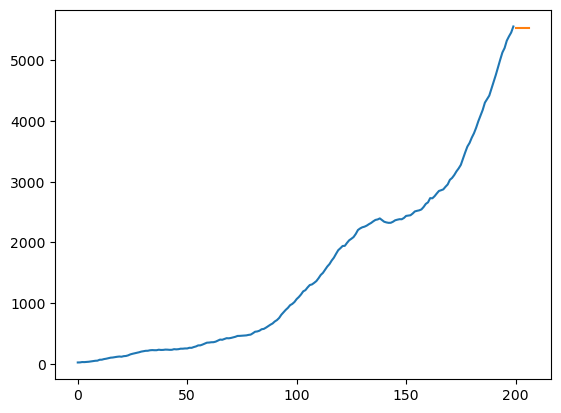

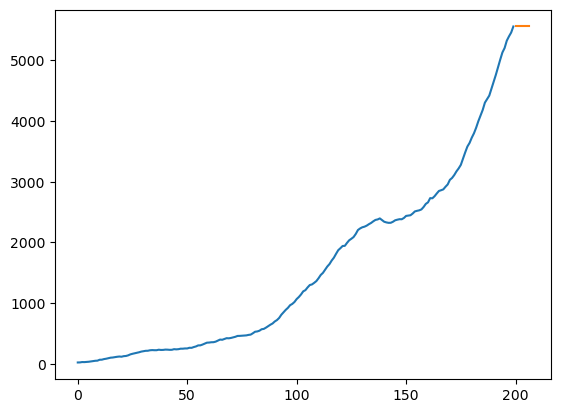

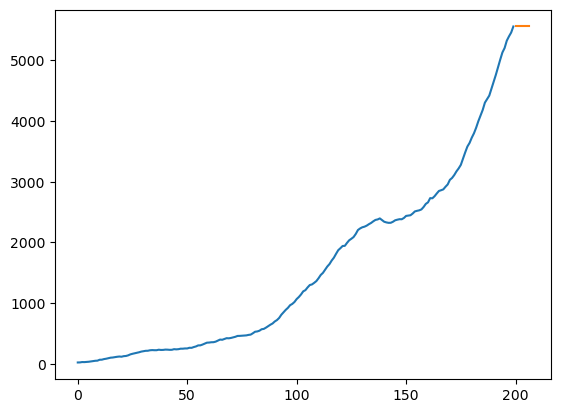

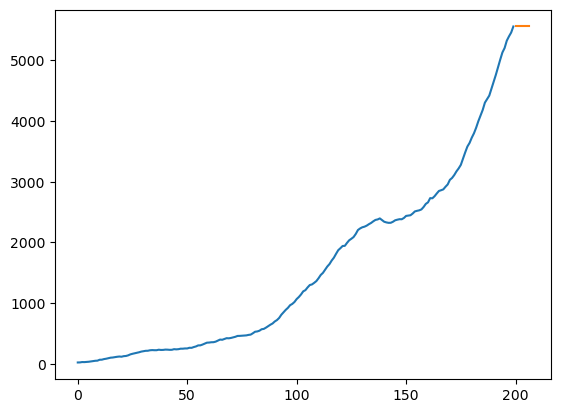

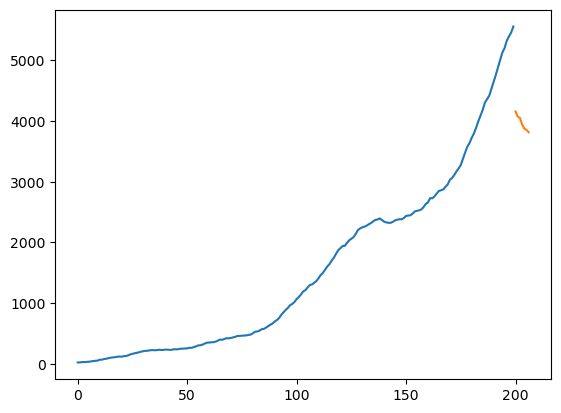

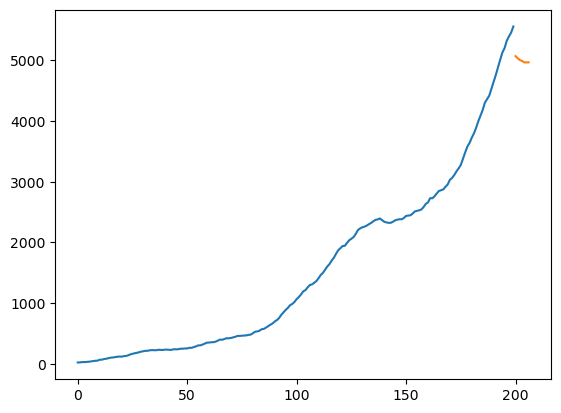

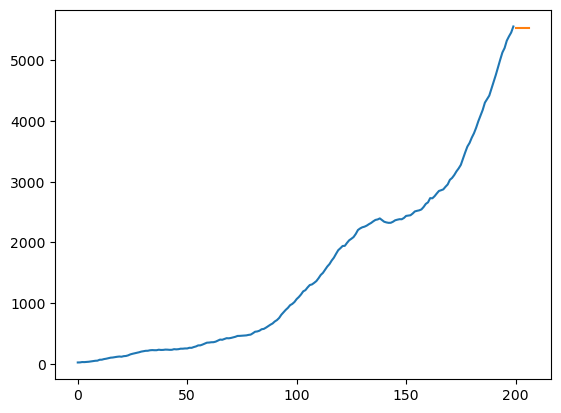

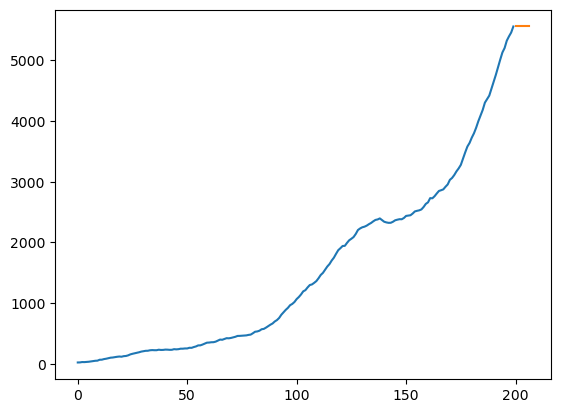

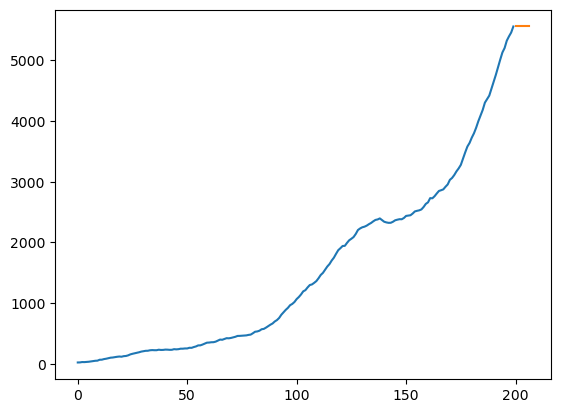

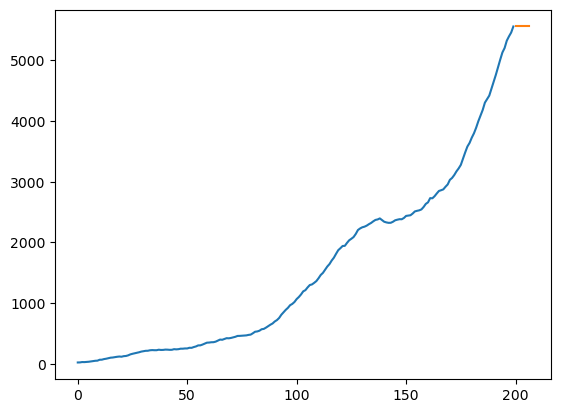

In [20]:
# same with gb : 
for depth in [2, 3, 4, 5, 6, 7]: 
    for n_estim in [10, 20, 50, 100, 150, 200]: 
        gb=GradientBoostingRegressor(max_depth=depth,  n_estimators=n_estim)
        gb.fit(datatrain, y_train)

        plt.plot(y_train)

        plt.plot([i for i in range(len(y_train), len(y_train)+7)], predict_model(gb, datatrain, y_train,  7), label='predict')
        plt.show()

In [ ]:
gb=GradientBoostingRegressor(max_depth=10,  n_estimators=20)
gb.fit(data_rf[:split], y_rf[:split])
predict=gb.predict(data_rf[split].reshape(1, -1))

